# Notebook showing a known-exoplanet yield estimation

This notebook shows how to use some of the newest features in psisim. It uses the upgraded universe.py class to pull confirmed planet data from the Exoplanet Archive. It then filters these planets to find reasonable VFN candidates based on basic properties (within VFN working region, reasonable mass, etc.). Those planets are fed into the updated spectrum.py which uses picaso to generate spectra for them. From there, we generate planet and host spectra and use observation.py to simulate the observation.

Updates to make:
- Make a second planet table to hold the modified values. _raw will be the original table as needed
- Simplify things in general so that there are less for-loops doing similar things
- Make better approximation of planet phase_angle (currently set to 0)
- Perform quick SNR analysis using the analytical equations from Gary's 2018 SPIE paper.

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import numpy as np
import time
import os
from importlib import reload
import speclite.filters
import copy
import astropy.units as u
from astropy.table import QTable, Table
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 5
#plt.rc('text', usetex=True)

## Telescope and instrument setup

In [2]:
#Setup the path to the peripheral files
path = '/scr3/dmawet/ETC/'
#Load the filter objects from speclite
filters = spectrum.load_filters()

In [3]:
#-- Telescope Setup
# Contains telescope params, site characteristics, and current conditions
keck = telescope.Keck(path=path)
keck.airmass=1.1
keck.water_vapor=1.6
keck.seeing = keck.median_seeing

In [4]:
#-- Instrument parameters
exp_time = 600           # [s]
main_filter = 'TwoMASS-K'   # Band for observation
n_exposures = 60
vort_charge = 1             # Vortex charge for VFN


#Initialize a kpic object and set the current filter
kpic = instrument.kpic_phaseII(telescope=keck)
kpic.set_current_filter(main_filter)

#Get the set of wavelengths based on the current instrument setup
wavelengths = kpic.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
kpic.set_observing_mode(exp_time,n_exposures,main_filter, wavelengths,mode="vfn",vortex_charge=vort_charge) 

## Create universe from Exoplanet Archive data

Load the universe from archive data

In [5]:
# Filename in which to save raw exoplanet archive table
archive_table_filename = "/scr3/dechever/Archive_Pull20210318.ecsv" 
# Instantiate universe object
uni = universe.ExoArchive_Universe(archive_table_filename)
# Pull and populate the planet table
uni.Load_ExoArchive_Universe(force_new_pull=False)

# Create easy-access table variables
planet_table = uni.planets
full_planet_table = copy.deepcopy(uni.planets)

# Display the table
planet_table

/scr3/dechever/Archive_Pull20210318.ecsv already exists:
    we'll attempt to read this file as an astropy QTable


PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 20794 c,HD 20794,0.2036,0.0,90.0,2.4,1.35,508.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,33.91761817024779,3.110698786682366
HD 20794 d,HD 20794,0.3499,0.0,90.0,4.8,2.04,388.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,58.289659124605606,3.053135984484562
HD 208487 b,HD 208487,0.524,0.24,nan,165.265,14.2,nan,329.3332489,-37.7641354,45.147,G2 V,1.13,6067.0,1.2,4.33,1.7538805018417611,8.15,4.61,5.49,-0.0,22.1214,8.023,7.47,nan,nan,6.477,6.213,6.159,Radial Velocity,nan,nan,nan,11.60652978049483,2.9047592811501257
HD 20868 b,HD 20868,0.95,0.75,nan,397.2875,13.7,nan,50.1794053,-33.72969,47.7223,K3/4 IV,0.39,4802.0,0.76,4.26,0.29580124665515456,4.5,1.1,46.12,-0.0,20.9257,10.935,9.92,nan,nan,8.138,7.641,7.543,Radial Velocity,nan,nan,nan,19.906836007484973,3.3168188485542527
HD 209458 b,HD 209458,0.04707,0.0,86.71,232.0159,15.581,1459.0,330.7950219,18.8842419,48.3016,G0 V,1.23,6091.0,1.19,4.45,1.7021585083949506,3.1,4.4,-14.74,-0.0,20.6745,8.168,7.65,nan,7.037,6.591,6.366,6.308,Radial Velocity,nan,nan,nan,0.9745018798549115,2.971482174841042
HD 210277 b,HD 210277,1.13,0.48,nan,410.0007,13.6,nan,332.3748117,-7.5505962,21.2985,G0 V,1.01,5538.0,1.07,4.38,0.9289663867799364,12.0,1.8,-21.1,-0.0,46.9229,7.296,6.54348,nan,5.765,5.275,4.957,4.799,Radial Velocity,nan,nan,nan,53.05537948681832,3.3368618634178238
HD 210702 b,HD 210702,1.148,0.028,nan,574.63664,13.4,nan,332.9638643,16.0404806,54.1963,K1 III,1.61,4951.0,4.92,3.28,14.092887984218748,2.1,1.99,16.39,-0.0,18.4231,6.895,5.93022,nan,nan,4.508,3.995,3.984,Radial Velocity,nan,nan,nan,21.182257829409018,3.496338799268739
HD 212301 b,HD 212301,0.03,0.0,nan,162.0933,14.2,nan,336.8803957,-77.7183219,54.2304,F8 V,1.55,6239.0,1.16,4.5,1.7498466886246569,1.0,7.0,4.87,-0.0,18.4109,8.314,7.76,nan,nan,6.765,6.522,6.466,Radial Velocity,nan,nan,nan,0.5531952557974862,2.896343457190833


## Select promising targets for modeling

##### First, remove planets missing key parameters needed for picaso

In [6]:
# Create masks for missing entries by (relevant) column
sma_mask = np.logical_not(np.isnan(planet_table['SMA']))
pms_mask = np.logical_not(np.isnan(planet_table['PlanetMass']))
prd_mask = np.logical_not(np.isnan(planet_table['PlanetRadius']))
plg_mask = np.logical_not(np.isnan(planet_table['PlanetLogg'])) 
  # ignore missing teq values since we deal with them later
ptq_mask = np.full(sma_mask.shape, True) #np.logical_not(np.isnan(planet_table['PlanetTeq']))  
slg_mask = np.logical_not(np.isnan(planet_table['StarLogg'])) 
stf_mask = np.logical_not(np.isnan(planet_table['StarTeff'])) 
srd_mask = np.logical_not(np.isnan(planet_table['StarRad']))

# Addtionally, remove planets missing AngSep
  # Not needed by picaso but needed for VFN part of simulations 
  # These entries are rare; the only 1 at the moment is beause of a missing star distance
ang_mask = np.logical_not(np.isnan(planet_table['AngSep']))

# Combine masks
com_mask = sma_mask & pms_mask & prd_mask & plg_mask & ptq_mask & slg_mask & stf_mask & srd_mask & ang_mask
print('Number of planets with sufficient information: %d'%np.sum(com_mask))

planet_table = planet_table[com_mask]

# Display the new table
planet_table

Number of planets with sufficient information: 4080


PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 20794 c,HD 20794,0.2036,0.0,90.0,2.4,1.35,508.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,33.91761817024779,3.110698786682366
HD 20794 d,HD 20794,0.3499,0.0,90.0,4.8,2.04,388.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,58.289659124605606,3.053135984484562
HD 208487 b,HD 208487,0.524,0.24,nan,165.265,14.2,nan,329.3332489,-37.7641354,45.147,G2 V,1.13,6067.0,1.2,4.33,1.7538805018417611,8.15,4.61,5.49,-0.0,22.1214,8.023,7.47,nan,nan,6.477,6.213,6.159,Radial Velocity,nan,nan,nan,11.60652978049483,2.9047592811501257
HD 20868 b,HD 20868,0.95,0.75,nan,397.2875,13.7,nan,50.1794053,-33.72969,47.7223,K3/4 IV,0.39,4802.0,0.76,4.26,0.29580124665515456,4.5,1.1,46.12,-0.0,20.9257,10.935,9.92,nan,nan,8.138,7.641,7.543,Radial Velocity,nan,nan,nan,19.906836007484973,3.3168188485542527
HD 209458 b,HD 209458,0.04707,0.0,86.71,232.0159,15.581,1459.0,330.7950219,18.8842419,48.3016,G0 V,1.23,6091.0,1.19,4.45,1.7021585083949506,3.1,4.4,-14.74,-0.0,20.6745,8.168,7.65,nan,7.037,6.591,6.366,6.308,Radial Velocity,nan,nan,nan,0.9745018798549115,2.971482174841042
HD 210277 b,HD 210277,1.13,0.48,nan,410.0007,13.6,nan,332.3748117,-7.5505962,21.2985,G0 V,1.01,5538.0,1.07,4.38,0.9289663867799364,12.0,1.8,-21.1,-0.0,46.9229,7.296,6.54348,nan,5.765,5.275,4.957,4.799,Radial Velocity,nan,nan,nan,53.05537948681832,3.3368618634178238
HD 210702 b,HD 210702,1.148,0.028,nan,574.63664,13.4,nan,332.9638643,16.0404806,54.1963,K1 III,1.61,4951.0,4.92,3.28,14.092887984218748,2.1,1.99,16.39,-0.0,18.4231,6.895,5.93022,nan,nan,4.508,3.995,3.984,Radial Velocity,nan,nan,nan,21.182257829409018,3.496338799268739
HD 212301 b,HD 212301,0.03,0.0,nan,162.0933,14.2,nan,336.8803957,-77.7183219,54.2304,F8 V,1.55,6239.0,1.16,4.5,1.7498466886246569,1.0,7.0,4.87,-0.0,18.4109,8.314,7.76,nan,nan,6.765,6.522,6.466,Radial Velocity,nan,nan,nan,0.5531952557974862,2.896343457190833


##### Next, downselect based on VFN coupling region

In [7]:
#Down select the planets whose separations are beyond VFN coupling region
iwa = 0.4*np.median(wavelengths).to(u.m)/keck.diameter*u.rad
owa = 1.4*np.median(wavelengths).to(u.m)/keck.diameter*u.rad

planet_table = planet_table[planet_table['AngSep'] > iwa.to(u.mas)]
planet_table = planet_table[planet_table['AngSep'] < owa.to(u.mas)]

# Display the new table
planet_table

PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 20794 c,HD 20794,0.2036,0.0,90.0,2.4,1.35,508.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,33.91761817024779,3.110698786682366
HD 20794 d,HD 20794,0.3499,0.0,90.0,4.8,2.04,388.0,49.9997666,-43.0666533,6.00278,G8 V,0.7,5401.0,0.92,4.22,0.6870684400142322,5.76,3.0,87.95,-0.5,166.561,4.966,4.26,nan,3.465,3.032,2.709,2.636,Radial Velocity,nan,nan,nan,58.289659124605606,3.053135984484562
HD 20868 b,HD 20868,0.95,0.75,nan,397.2875,13.7,nan,50.1794053,-33.72969,47.7223,K3/4 IV,0.39,4802.0,0.76,4.26,0.29580124665515456,4.5,1.1,46.12,-0.0,20.9257,10.935,9.92,nan,nan,8.138,7.641,7.543,Radial Velocity,nan,nan,nan,19.906836007484973,3.3168188485542527
HD 210277 b,HD 210277,1.13,0.48,nan,410.0007,13.6,nan,332.3748117,-7.5505962,21.2985,G0 V,1.01,5538.0,1.07,4.38,0.9289663867799364,12.0,1.8,-21.1,-0.0,46.9229,7.296,6.54348,nan,5.765,5.275,4.957,4.799,Radial Velocity,nan,nan,nan,53.05537948681832,3.3368618634178238
HD 210702 b,HD 210702,1.148,0.028,nan,574.63664,13.4,nan,332.9638643,16.0404806,54.1963,K1 III,1.61,4951.0,4.92,3.28,14.092887984218748,2.1,1.99,16.39,-0.0,18.4231,6.895,5.93022,nan,nan,4.508,3.995,3.984,Radial Velocity,nan,nan,nan,21.182257829409018,3.496338799268739
HD 213240 b,HD 213240,1.89,0.42,nan,1773.4914,12.8,nan,337.7506266,-49.4341037,40.8707,G0/1 V,1.57,5979.0,1.51,4.27,2.685344445658507,4.6,3.97,-0.45,-0.0,24.4385,7.425,6.81,nan,nan,5.708,5.482,5.354,Radial Velocity,nan,nan,nan,46.24339685887445,4.025564229500851
HD 215497 c,HD 215497,1.282,0.49,nan,104.3,12.5,nan,341.652714,-56.5997984,40.5468,K3 V,0.87,5113.0,0.9,4.31,0.3890451449942806,7.0,1.67,49.31,-0.0,24.6339,9.918,8.96,nan,nan,7.339,6.917,6.784,Radial Velocity,nan,nan,nan,31.617784880681093,2.8156193643711904
HD 217786 b,HD 217786,2.38,0.4,nan,4131.62,12.3,nan,345.7838088,-0.4303594,55.4847,F8 V,1.02,5966.0,1.27,4.35,1.8879913490962936,7.6,1.4,9.98,-0.0,17.9946,8.285,7.78,nan,nan,6.685,6.416,6.352,Radial Velocity,nan,nan,nan,42.89470791046901,4.427465230135711


##### Make additional cuts based on mass

In [8]:
# Make sure we're in the giant planet regime for now
planet_table = planet_table[planet_table['PlanetMass'].to(u.earthMass).value > 130]
# Remove objects above the hydrogen burning limit
planet_table = planet_table[planet_table['PlanetMass'].to(u.earthMass).value < 4200]

# Display the new table
planet_table

PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 20868 b,HD 20868,0.95,0.75,nan,397.2875,13.7,nan,50.1794053,-33.72969,47.7223,K3/4 IV,0.39,4802.0,0.76,4.26,0.29580124665515456,4.5,1.1,46.12,-0.0,20.9257,10.935,9.92,nan,nan,8.138,7.641,7.543,Radial Velocity,nan,nan,nan,19.906836007484973,3.3168188485542527
HD 210277 b,HD 210277,1.13,0.48,nan,410.0007,13.6,nan,332.3748117,-7.5505962,21.2985,G0 V,1.01,5538.0,1.07,4.38,0.9289663867799364,12.0,1.8,-21.1,-0.0,46.9229,7.296,6.54348,nan,5.765,5.275,4.957,4.799,Radial Velocity,nan,nan,nan,53.05537948681832,3.3368618634178238
HD 210702 b,HD 210702,1.148,0.028,nan,574.63664,13.4,nan,332.9638643,16.0404806,54.1963,K1 III,1.61,4951.0,4.92,3.28,14.092887984218748,2.1,1.99,16.39,-0.0,18.4231,6.895,5.93022,nan,nan,4.508,3.995,3.984,Radial Velocity,nan,nan,nan,21.182257829409018,3.496338799268739
HD 213240 b,HD 213240,1.89,0.42,nan,1773.4914,12.8,nan,337.7506266,-49.4341037,40.8707,G0/1 V,1.57,5979.0,1.51,4.27,2.685344445658507,4.6,3.97,-0.45,-0.0,24.4385,7.425,6.81,nan,nan,5.708,5.482,5.354,Radial Velocity,nan,nan,nan,46.24339685887445,4.025564229500851
HD 217786 b,HD 217786,2.38,0.4,nan,4131.62,12.3,nan,345.7838088,-0.4303594,55.4847,F8 V,1.02,5966.0,1.27,4.35,1.8879913490962936,7.6,1.4,9.98,-0.0,17.9946,8.285,7.78,nan,nan,6.685,6.416,6.352,Radial Velocity,nan,nan,nan,42.89470791046901,4.427465230135711
HD 221287 b,HD 221287,1.25,0.08,nan,982.05,13.1,nan,352.836223,-58.209754,55.9231,F7 V,1.25,6304.0,1.14,4.43,1.6595869074375607,1.3,3.92,-21.9,-0.0,17.8529,8.270001,7.82,nan,nan,6.843,6.616,6.569,Radial Velocity,nan,nan,nan,22.352122825809012,3.7487460906269217
HD 222582 b,HD 222582,1.34,0.73,nan,2660.2371,12.6,nan,355.4640788,-5.9862379,42.1586,G5 V,1.12,5790.0,1.13,4.38,1.3031667784522993,10.24,2.3,12.09,-0.0,23.6913,8.286,7.68,nan,nan,6.522,6.243,6.173,Radial Velocity,nan,nan,nan,31.78473668480453,4.2153343376171435
HD 23079 b,HD 23079,1.6,0.1,nan,829.5363,13.2,nan,54.9281897,-52.9162344,33.4591,F9.5 V,1.12,5974.0,1.07,4.43,1.3583134465871542,2.0,2.99,0.62,-0.0,29.8583,7.634,7.12,nan,nan,6.03,5.814,5.705,Radial Velocity,nan,nan,nan,47.81957673697141,3.668842614785591


##### Since we have so many planet options, let's manually choose some we think might do well

In [9]:
st2find = ['HD 86226', 'GJ 3021', 'HD 169830', 'Missing_Planet']
inds = []
for st in st2find:
    try:
        inds.append(np.where(planet_table['StarName'] == st)[0][0])
    except:
        print('Star %s was missing from the table!'%st)
    
planet_table = planet_table[inds]

planet_table

Star Missing_Planet was missing from the table!


PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 86226 b,HD 86226,2.73,0.059,nan,143.0235,14.3,176.0,149.1235154,-24.0991859,45.683,G1 V,1.02,5863.0,1.05,4.4,1.1803206356517297,4.6,2.4,19.74,-0.0,21.8612,8.432,7.93,nan,nan,6.839,6.577,6.463,Radial Velocity,nan,nan,nan,59.759648009106236,2.8358904087042296
GJ 3021 b,GJ 3021,0.49,0.511,nan,1071.04,13.1,350.0,4.0634323,-79.8514218,17.5559,G6 V,0.9,5540.0,0.9,4.7,0.660693448007596,0.37,5.5,-5.81,-0.0,56.9319,7.352,6.59,nan,nan,5.366,4.99,4.859,Radial Velocity,nan,nan,nan,27.910844787222526,3.786418181326927
HD 169830 b,HD 169830,0.81,0.31,nan,915.31,13.2,345.0,276.9561859,-29.8167919,37.6048,F8 V,1.4,6299.0,1.2,4.1,4.591980128368687,2.8,3.3,-17.21,-0.0,26.5642,6.407,5.9,nan,nan,4.974,4.778,4.688,Radial Velocity,nan,nan,nan,21.539803429349448,3.7115754267173204


#### FOR NOW: set phase to 0 for all planets.

#### WE SHOULD find a good way to decide on the planet phase

In [10]:
planet_table['Phase'][:] = 0.0 *u.rad

##### NOTE: an intermediate spectrum is not necessary for this particular simulation since we are checking detectability and Jason's high-res opacity files already have a very similar resolution to KPIC

## Define function to generate planet spectrum

In [11]:
# Define opacity file to load
opacity_folder = os.path.join(os.getenv("picaso_refdata"),'opacities')
dbname = 'Natasha Batalha - opacity_K.db'
dbname = os.path.join(opacity_folder,dbname)
# Define wavelength range for opacity file
  # Not required but will reduce picaso runtime since not simulating unused wavelengths
  # Set slightly larger than requested wvs due to apparent picaso internal rounding on wave_range
  # such that going beyond range isn't an issue
wvrng = [wavelengths.min().value*0.98, wavelengths.max().value*1.02]

# Load opacity file
opacity = spectrum.load_picaso_opacity(dbname=dbname,wave_range=wvrng)

# Function that actually does the simulation
def generate_spectrum(planet):
    """
    Function to loop over to generate spectra.
    """
    # For now, we'll assume user has filtered planet table so that 
    #  all planets are gas giants. This is because the psisim picaso
    #  implementation is limited to gas giants for now
    planet_type = "Gas"
    print('-----')
    print('  STARTING NEW PLANET')
    print('Planet Name: %s'%planet['PlanetName'])
    
    # Extract planet equilibrium temperature
    # Unecessary right now due to earlier masking but maybe useful laeter
    if not np.isnan(planet['PlanetTeq']):
        planet_teq = planet['PlanetTeq'].value
        print('Planet Teq in use: %0.1f'%planet_teq)
    else:
        print('Planet Teq in use: None')
        planet_teq = None
    
    # Feed in stellar metalicity
      # Used by picaso to get stellar spectrum from pysynphot. 
      # Might not be used in our setup since we are extracting the thermal spectrum directly, not fpfs
      # let's not use this at the moment just to keep things simple
    #stellar_mh = planet['StarZ'].value if not  
    
    # Generate spectrum
    time1 = time.time()
    atmospheric_parameters = spectrum.generate_picaso_inputs(planet,planet_type,opacity,clouds=True,planet_teq=planet_teq)
    fpfs_ref, fp_therm, df = spectrum.simulate_spectrum(planet,wavelengths,kpic.current_R,atmospheric_parameters)
    print('Spectrum took {0:.3f} s'.format(time.time()-time1))
    
    return fpfs_ref, fp_therm, df

## Generate spectra!

##### NOTE: we will iterate over the full planet table below so make sure you've culled the planet_table to be small enough so that this iteration is manageable

In [12]:
fpfs_ref_list = []
fp_therm_list = []

for planet in planet_table:
    fpfs_ref, fp_therm, df = generate_spectrum(planet)
    fpfs_ref_list.append(fpfs_ref)
    fp_therm_list.append(fp_therm)
    
fpfs_ref_list = np.array(fpfs_ref_list) 
fp_therm_list = np.array(fp_therm_list) * fp_therm_list[0].unit

-----
  STARTING NEW PLANET
Planet Name: HD 86226 b
Planet Teq in use: 176.0


/home/dechever/Code/psisim/psisim/spectrum.py:159: UserWarning: The requested wavelength range [1.950000, 2.449987] is outside the range selected [1.980010, 2.379990] from the opacity model (/home/dechever/Code/picaso/reference/opacities/Natasha Batalha - opacity_K.db)
  warnings.warn(err)    # TODO: warn for now until we get higher res opacity files
/home/dechever/anaconda3/lib/python3.7/site-packages/picaso-2.1-py3.7.egg/picaso/atmsetup.py:185: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/home/dechever/anaconda3/lib/python3.7/site-packages/picaso-2.1-py3.7.egg/picaso/atmsetup.py:185: UserWarning: Ignoring lithium(c) in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/home/dechever/anaconda3/lib/python3.7/site-packages/picaso-2.1-py3.7.egg/picaso/atmsetup.py:185: UserWarning: Ignoring ptid in

Spectrum took 6.945 s
-----
  STARTING NEW PLANET
Planet Name: GJ 3021 b
Planet Teq in use: 350.0
Spectrum took 6.166 s
-----
  STARTING NEW PLANET
Planet Name: HD 169830 b
Planet Teq in use: 345.0
Spectrum took 6.426 s


Plot the reflected spectra (in native contrast units)

##### The edges of the spectrum are flat because the opacity file does not extend as far as the wavelengths vector requested

In [ ]:
for ind in range(len(planet_table)):
    plt.figure(figsize=(30,10))
    plt.semilogy(wavelengths,fpfs_ref_list[ind])
    plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
    plt.ylabel("Spectrum [contrast]")
    plt.title("Refl. Spec: Planet %s"%planet_table['PlanetName'][ind])

Plot the un-normalized thermal spectrum in ph/s/cm2/Ang as returned by simulate_spectrum()

In [ ]:
for ind in range(len(planet_table)):
    plt.figure(figsize=(30,10))
    plt.semilogy(wavelengths,fp_therm_list[ind])
    plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
    plt.ylabel("Spectrum\n[{}]".format(fp_therm_list[ind].unit))
    plt.title("Planet %s"%planet_table['PlanetName'][ind])

##### The thermal spectrum needs to be in contrast units for psisim; let's compute it as such

We'll define a function that pulls out the pertinent stellar properties, gets the raw phoenix specrtrum, and normalizes the picaso spectrum by it correctly

It'll also automatically compute the full host spectrum that psisim will use later (since we already have everything we need here for it)

In [15]:
# Options for the star properties
host_temp_list=np.hstack([np.arange(2300,7000,100),np.arange(7000,12200,200)])
host_logg_list=[6.00,5.50,5.00,4.50,4.00,3.50,3.00,2.50,2.00,1.50,1.00,0.50]

# Create valid grids
f_teff_grid=interp1d(host_temp_list,host_temp_list,kind='nearest')
f_logg_grid=interp1d(host_logg_list,host_logg_list,kind='nearest')

def picaso2contrast(planet,fp_thermal):
    import warnings
    
    print('-----')
    print('  STARTING NEW PLANET')
    
    #-- Push values towards requisite for models
    host_temp = int(f_teff_grid(planet['StarTeff'])) *planet['StarTeff'].unit
    host_logg = f_logg_grid(planet['StarLogg'])  *planet['StarLogg'].unit
    host_mag  = planet['StarKmag']
    host_radV = planet['StarRadialVelocity'] if not np.isnan(planet['StarRadialVelocity']) else 0*u.km/u.s
    print('Planet: %15s | STeff: %7d | SLogg: %7.2f | SKmag: %5.2f'%(planet['PlanetName'],host_temp.value,host_logg.value,host_mag))
    print('                        | SRadV:  %6.2f | SVsini: %6.2f'%(host_radV.value,planet['StarVsini'].value))
    print('  Inputs:               | Steff: %7.2f | Slogg: %7.2f | SRadV: %6.2f'%(planet['StarTeff'].value,planet['StarLogg'].value,planet['StarRadialVelocity'].value))
    print()
    
    # set the host properties for a Phoenix model.
    host_properties = {"StarLogg":host_logg,"StarTeff":host_temp,"StarZ":'-0.0',"StarAlpha":"0.0",
                        "StarRadialVelocity": host_radV,
                        "StarVsini": planet['StarVsini'],
                        "StarLimbDarkening": 0.2}
    
    #Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
    # filters_object,current_filter). 
    host_filter = 'TwoMASS-K'
    host_user_params = (path,host_filter,host_mag,filters,kpic.current_filter)
    
    doppler_shift=True
    broaden=True
    delta_wv=kpic.current_dwvs

    #Read the spectrum as will be done in get_stellar_spectrum() but removing scaling stuff
    host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,kpic.current_R,model="Phoenix",
                                                  user_params=host_user_params,doppler_shift=doppler_shift,broaden=broaden,
                                                  delta_wv=delta_wv)

    # Get the StarAOmag (needed later for AO magnitude in observation sim)
    host_properties["StarAOmag"] = spectrum.get_model_ABmags(host_properties,[kpic.ao_filter],model="Phoenix",
                                                             verbose=False,user_params=host_user_params)
    # Set spectral type (though not used, might as well get used to it)
    host_properties["StarSpT"] = planet["StarSpT"]
    
    available_filters = filters.names
    if host_filter not in available_filters:
        raise ValueError("Your stellar filter of {} is not a valid option. Please choose one of: {}".format(host_filter,available_filters))

    try: 
        host_z = host_properties['StarZ']
    except Exception as e: 
        print(e)
        print("Some error in reading your star Z value, setting Z to zero")
        host_z = '-0.0'

    try: 
        host_alpha = host_properties['StarAlpha']
    except Exception as e:
        print(e)
        print("Some error in reading your star alpha value, setting alpha to zero")
        host_alpha ='0.0'

    #Read in the model spectrum        
    wave_u,spec_u = spectrum.get_phoenix_spectrum(host_properties['StarLogg'].to(u.dex(u.cm/ u.s**2)).value,host_properties['StarTeff'].to(u.K).value,host_z,host_alpha,path=path)

    #Get the wavelength sampling of the stellar spectrum
    dwvs_u = wave_u - np.roll(wave_u, 1)
    dwvs_u[0] = dwvs_u[1]
    mean_R_in = np.mean(wave_u/dwvs_u)

    if kpic.current_R < mean_R_in:
        ds = spectrum.downsample_spectrum(spec_u,mean_R_in,kpic.current_R)
    else:
        wargnings.warn("Your requested Resolving power is greater than or equal to the native model. We're not upsampling here, but we should.")
        ds = spec_u

    stellar_spectrum = np.interp(wavelengths,wave_u,ds)
    
    stellar_spectrum *= spec_u.unit
    
        ## Apply a doppler shift if you'd like.
    if doppler_shift:
        if delta_wv is not None:
            if "StarRadialVelocity" in host_properties.keys():                
                stellar_spectrum = spectrum.apply_doppler_shift(wavelengths,stellar_spectrum,delta_wv,host_properties['StarRadialVelocity'].to(u.km/u.s).value)
            else:
                raise KeyError("The StarRadialVelocity key is missing from your target table. It is needed for a doppler shift. ")
        else: 
            print("You need to pass a delta_wv keyword to get_stellar_spectrum to apply a doppler shift")
    
    # import pdb;pdb.set_trace()
    ## Rotationally broaden if you'd like
    if broaden:
        if ("StarVsini" in host_properties.keys()) and ("StarLimbDarkening" in host_properties.keys()):
            stellar_spectrum = spectrum.rotationally_broaden(wavelengths,stellar_spectrum,host_properties['StarLimbDarkening'],host_properties['StarVsini'])
        else:
            raise KeyError("The StarVsini key is missing from your target table. It is needed for a doppler shift. ")
            
    # Convert spectrum to ergs/s/cm3 as needed for normalization with picaso planet spectrum
    stellar_spectrum = stellar_spectrum.to(u.erg/u.s/u.cm**2/u.cm,equivalencies=u.spectral_density(wavelengths))
    fp_thermal = fp_thermal.to(u.erg/u.s/u.cm**2/u.cm,equivalencies=u.spectral_density(wavelengths))
    
    # Compute fpfs_thermal as done in picaso
    fpfs_thermal_ours = fp_thermal/(stellar_spectrum)*(planet['PlanetRadius']/planet['StarRad']).decompose()**2
    
    return fpfs_thermal_ours, host_spectrum, host_properties
    
    
    

##### Iterate through planet table computing thermal spectrum in contrast units and getting the host spectrum

In [16]:
fpfs_therm_list = []
host_spec_list = []
host_prop_list = []

for ind,planet in enumerate(planet_table):
    fpfs_therm, host_spec, host_prop = picaso2contrast(planet,fp_therm_list[ind])
    fpfs_therm_list.append(fpfs_therm)
    host_spec_list.append(host_spec)
    host_prop_list.append(host_prop)
    
fpfs_therm_list = np.array(fpfs_therm_list) 
host_spec_list = np.array(host_spec_list) * fp_therm_list[0].unit

-----
  STARTING NEW PLANET
Planet:      HD 86226 b | STeff:    5900 | SLogg:    4.50 | SKmag:  6.46
                        | SRadV:   19.74 | SVsini:   2.40
  Inputs:               | Steff: 5863.00 | Slogg:    4.40 | SRadV:  19.74



/home/dechever/anaconda3/lib/python3.7/site-packages/speclite/filters.py:1461: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/home/dechever/anaconda3/lib/python3.7/site-packages/astropy-4.2-py3.7-linux-x86_64.egg/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


-----
  STARTING NEW PLANET
Planet:       GJ 3021 b | STeff:    5500 | SLogg:    4.50 | SKmag:  4.86
                        | SRadV:   -5.81 | SVsini:   5.50
  Inputs:               | Steff: 5540.00 | Slogg:    4.70 | SRadV:  -5.81

-----
  STARTING NEW PLANET
Planet:     HD 169830 b | STeff:    6300 | SLogg:    4.00 | SKmag:  4.69
                        | SRadV:  -17.21 | SVsini:   3.30
  Inputs:               | Steff: 6299.00 | Slogg:    4.10 | SRadV: -17.21



##### Display the thermal spectra!

In [ ]:
for ind in range(len(planet_table)):
    plt.figure(figsize=(30,10))
    plt.semilogy(wavelengths,fpfs_therm_list[ind])
    plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
    plt.ylabel("Spectrum [contrast]")
    plt.title("Therm. Spec: Planet %s, Temp: %.2f K, Mass: %.2f M_J, Rad: %.2f R_J, AngSep: %.1f"%(planet_table['PlanetName'][ind],
                    planet_table['PlanetTeq'][ind].value, planet_table['PlanetMass'][ind].to(u.jupiterMass).value,
                    planet_table['PlanetRadius'][ind].to(u.jupiterRad).value, planet_table['AngSep'][ind].value))

Display Thermal- and Reflected-light spectra super-imposed

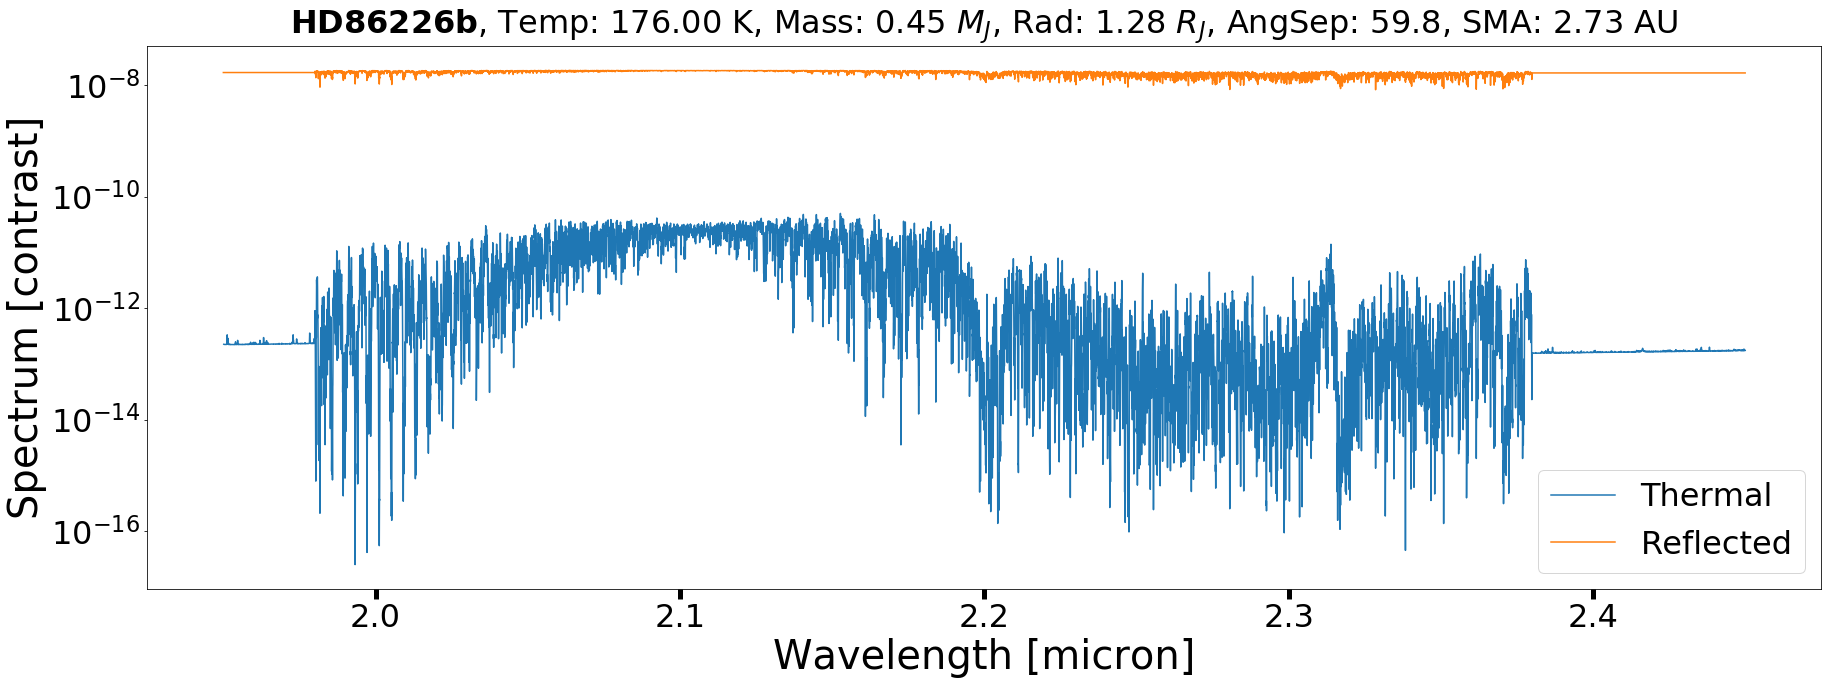

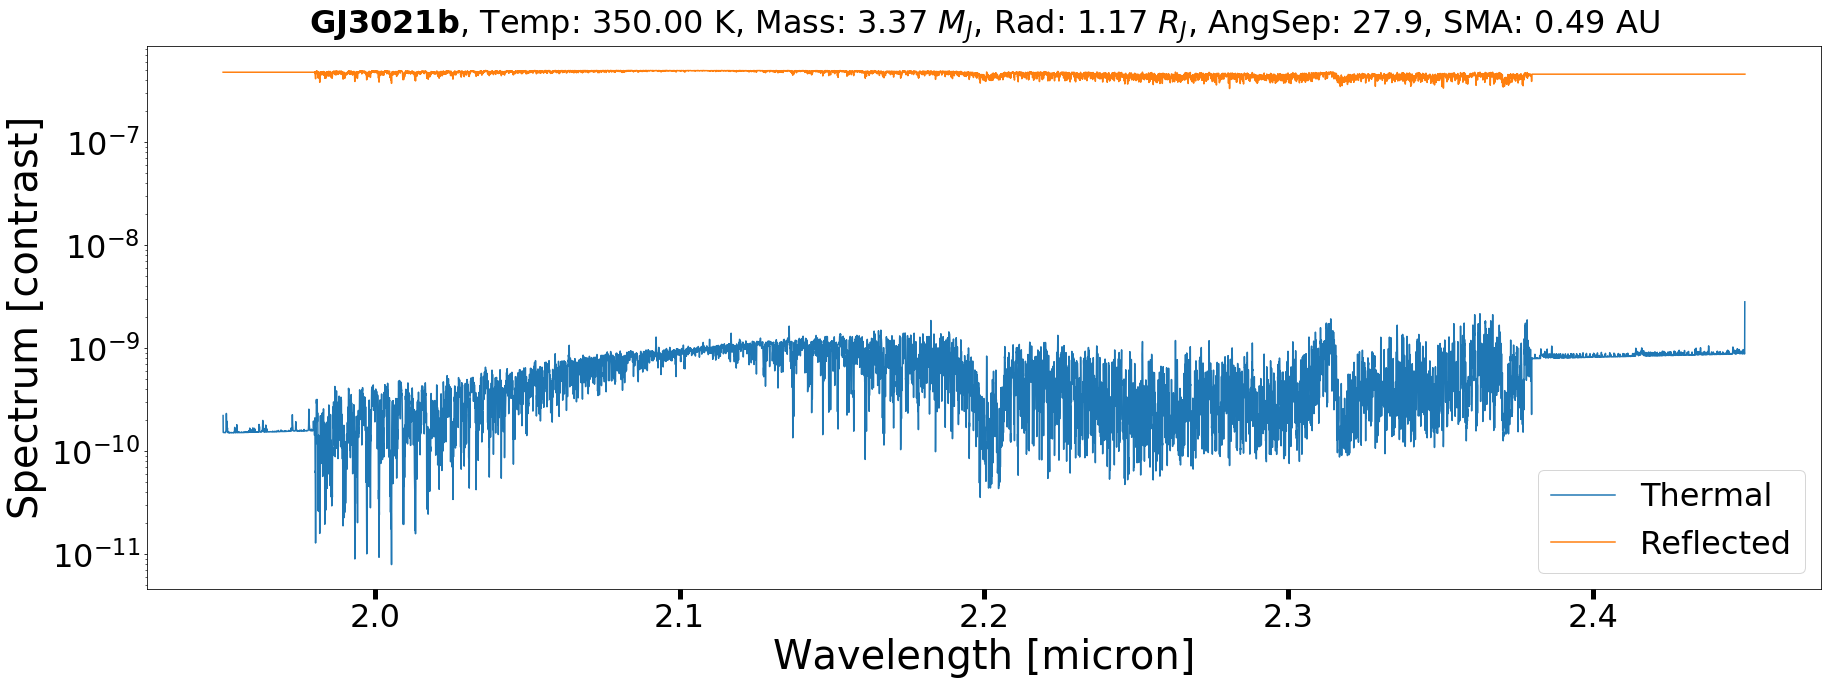

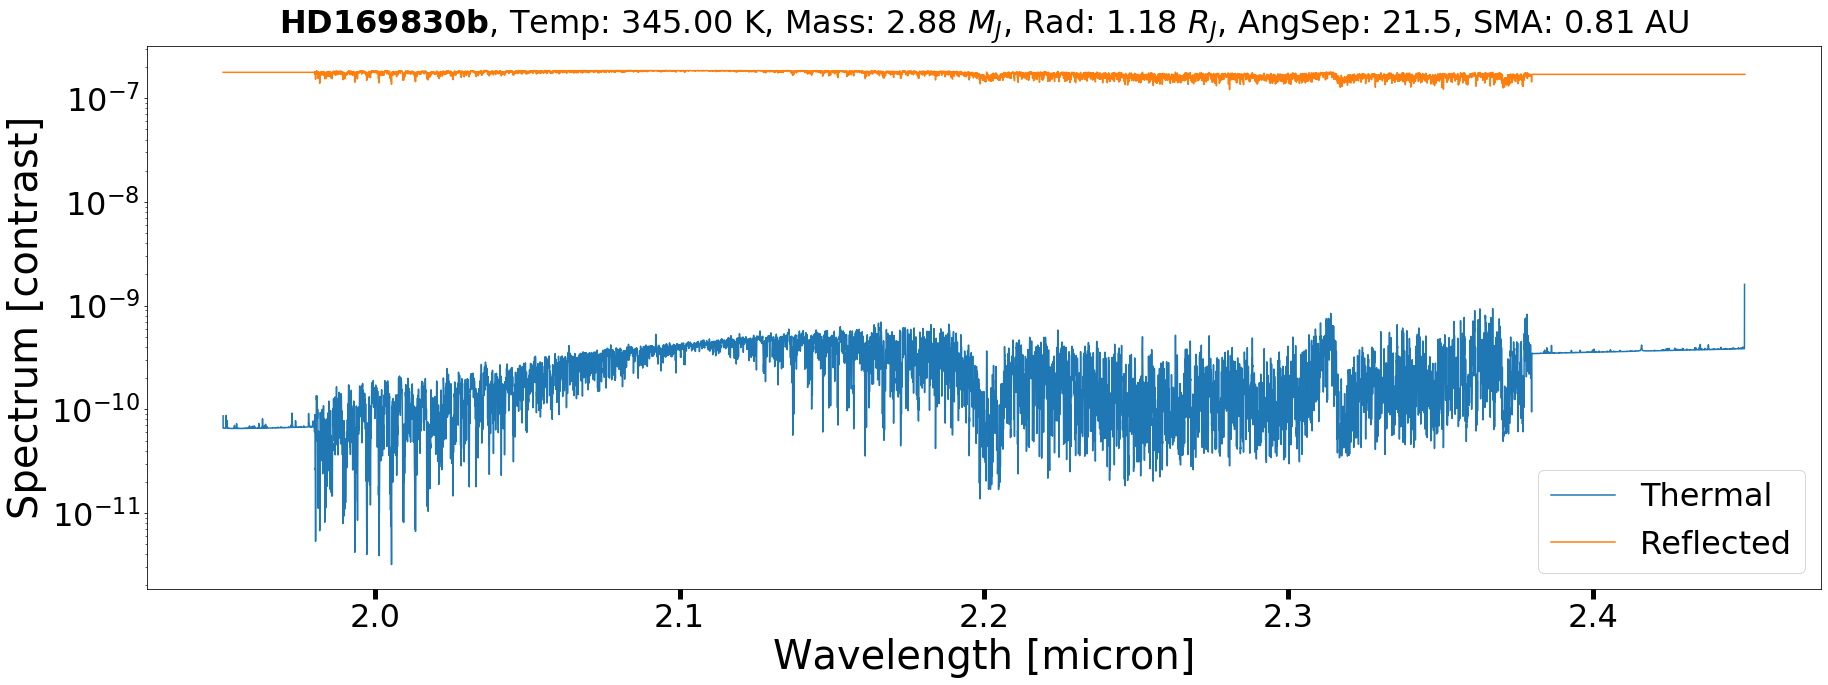

In [18]:
for ind in range(len(planet_table)):    
    plt.figure(figsize=(30,10))
    plt.semilogy(wavelengths,fpfs_therm_list[ind],label="Thermal")
    plt.semilogy(wavelengths,fpfs_ref_list[ind],label="Reflected")
    plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
    plt.ylabel("Spectrum [contrast]")
    plt.title(r"$\bf{%s}$, Temp: %.2f K, Mass: %.2f $M_J$, Rad: %.2f $R_J$, AngSep: %.1f, SMA: %0.2f AU"%(planet_table['PlanetName'][ind],
                planet_table['PlanetTeq'][ind].value, planet_table['PlanetMass'][ind].to(u.jupiterMass).value,
                planet_table['PlanetRadius'][ind].to(u.jupiterRad).value, planet_table['AngSep'][ind].value,
                planet_table['SMA'][ind].value))
    plt.legend()

Let's plot the last planet's picaso spectrum with it's two normalizations: a) the internal picaso stellar spectrum vs. b) our phoenix spectrum. This shows that our fpfs calculation is very similar to picaso's but it uses our host spectrum like we want it to!

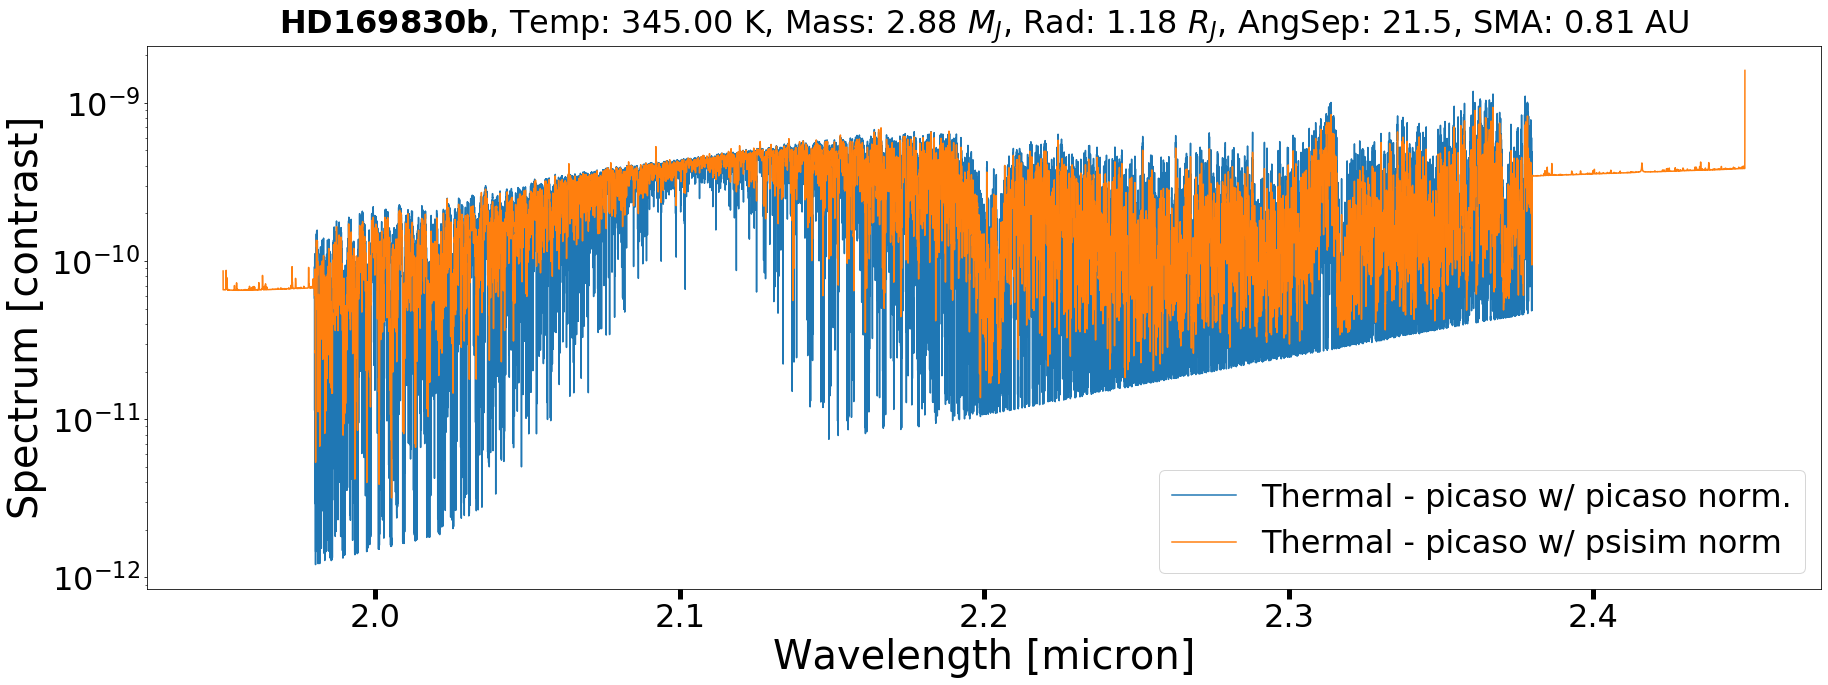

In [19]:
ind = 2
plt.figure(figsize=(30,10))
plt.semilogy(1/df['wavenumber'] * 1e4,df['fpfs_thermal'],label="Thermal - picaso w/ picaso norm.")
plt.semilogy(wavelengths,fpfs_therm_list[ind],label="Thermal - picaso w/ psisim norm")
plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [contrast]")
plt.title(r"$\bf{%s}$, Temp: %.2f K, Mass: %.2f $M_J$, Rad: %.2f $R_J$, AngSep: %.1f, SMA: %0.2f AU"%(planet_table['PlanetName'][ind],
            planet_table['PlanetTeq'][ind].value, planet_table['PlanetMass'][ind].to(u.jupiterMass).value,
            planet_table['PlanetRadius'][ind].to(u.jupiterRad).value, planet_table['AngSep'][ind].value,
            planet_table['SMA'][ind].value))
plt.legend()

Plot host spectra with magnitude corrections and all

In [ ]:
for ind in range(len(planet_table)):    
    plt.figure(figsize=(30,10))
    plt.semilogy(wavelengths,host_spec_list[ind])
    plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
    plt.ylabel("Host Spectrum\n[{}]".format(host_spec_list[ind].unit))
    plt.title(r"$\bf{%s}$ - STemp: %.2f K, SLogg: %.2f log(cgs), Age: %.2f Gyr, Dist: %.0f pc, K-mag: %0.2f"%(planet_table['PlanetName'][ind],
                planet_table['StarTeff'][ind].value, planet_table['StarLogg'][ind].value,
                planet_table['StarAge'][ind].value, planet_table['Distance'][ind].value,
                planet_table['StarKmag'][ind]))

## Simulate observations

In [21]:
obj_spec_list = []
total_noise_list = []
stellar_spec_list = []
thermal_spec_list = []
noise_components_list = []
obj_spec_nosky_list = []
systematics_list = []
noise_plus_syst_list = []
ccf_list = []

#-- Calibration properties
cal = 0.001 #Telluric calibration accuracy of 0.1%

for ind, planet in enumerate(planet_table):
    # Compute stellar diameter (using small angle approx)
    host_diam = ((2*planet['StarRad']/planet['Distance']).decompose()*u.rad).to(u.mas).value
    # Set host diameter for VFN mode
    kpic.set_vfn_host_diameter(host_diam)
    
    host_prop = host_prop_list[ind]
    host_prop['AngSep'] = planet['AngSep']
    kpic.ao_mag = host_prop['StarAOmag']
    
    obj_spec = fpfs_ref_list[ind]
    
    #-- Simulate a regular observation
    obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(keck,kpic,host_prop,
                                                                                          obj_spec,wavelengths,1e5,
                                                                                          inject_noise=False,verbose=True,
                                                                                          post_processing_gain = np.inf,
                                                                                          return_noise_components=True,
                                                                                          stellar_spec=host_spec_list[ind],
                                                                                          apply_lsf=True,
                                                                                          integrate_delta_wv=False, 
                                                                                          plot=False,
                                                                                          sky_on=True)

    #-- Simulate observation without sky effects
    obj_spec_no_sky,_,_,_ = observation.simulate_observation(keck,kpic,
                                                                                          host_prop,
                                                                                          obj_spec,wavelengths,1e5,
                                                                                          inject_noise=False,verbose=True,
                                                                                          post_processing_gain = np.inf,
                                                                                          return_noise_components=False,
                                                                                          stellar_spec=host_spec_list[ind],
                                                                                          apply_lsf=True,
                                                                                          integrate_delta_wv=False,
                                                                                          plot=False,
                                                                                          sky_on=False)

    #-- Get speckle noise
    speckle_noise = kpic.get_speckle_noise(planet['AngSep'].to(u.arcsec),host_prop['StarAOmag'],kpic.current_filter,wavelengths,host_prop['StarSpT'],keck)[0]

    #-- Compute Systematics
    #The photon flux at the object will be the stellar flux multipled by the contrast there:
    host_flux_at_obj = stellar_spec*speckle_noise

    systematics = (cal*(host_flux_at_obj+thermal_spec))**2 #Variance of systematics

    noise_plus_systematics = np.sqrt(total_noise**2+systematics)

    #-- Calculate CCF SNR
    #Compute sky transmission lines convolved with line spread function
    #Get the wavelength spacing
    dwvs = np.abs(wavelengths - np.roll(wavelengths, 1))
    dwvs[0] = dwvs[1]
    dwv_mean = np.mean(dwvs)
    lsf_fwhm = (kpic.lsf_width/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
    lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma
    #Get sky transmission lsf
    sky_transmission_lsf = gaussian_filter(keck.get_atmospheric_transmission(wavelengths),lsf_sigma.value)

    #-- Crop the pertinent spectra so that CCF is only done over the region that is well defined for all spectra
    # index of shortest overlapping wavelength
    wv_min_ind = np.argmin(np.abs(opacity.wave.min()-wavelengths.value))+1
    # index of longest overlapping wavelength
    wv_max_ind = np.argmin(np.abs(opacity.wave.max()-wavelengths.value))-1
    
    obj_spec2 = obj_spec[wv_min_ind:wv_max_ind]
    obj_spec_no_sky2 = obj_spec_no_sky[wv_min_ind:wv_max_ind]
    noise_plus_systematics2 = noise_plus_systematics[wv_min_ind:wv_max_ind]
    sky_transmission_lsf2 = sky_transmission_lsf[wv_min_ind:wv_max_ind]
    
    #Get CCF SNR
    ccf_snr = signal.compute_ccf_snr_matchedfilter(obj_spec2, obj_spec_no_sky2, noise_plus_systematics2, 
                                                sky_transmission_lsf2,
                                                   systematics_residuals = cal, 
                                                   norm_cutoff=0.8)
    
    # Save everything:
    obj_spec_list.append(obj_spec)
    total_noise_list.append(total_noise)
    stellar_spec_list.append(stellar_spec)
    thermal_spec_list.append(thermal_spec)
    noise_components_list.append(noise_components)
    obj_spec_nosky_list.append(obj_spec_no_sky)
    systematics_list.append(systematics)
    noise_plus_syst_list.append(noise_plus_systematics)
    ccf_list.append(ccf_snr.value)
    
    
obj_spec_list = np.array(obj_spec_list)
total_noise_list = np.array(total_noise_list)
stellar_spec_list = np.array(stellar_spec_list)
thermal_spec_list = np.array(thermal_spec_list)
noise_components_list = np.array(noise_components_list)
obj_spec_nosky_list = np.array(obj_spec_nosky_list)
systematics_list = np.array(systematics_list)
noise_plus_syst_list = np.array(noise_plus_syst_list)
ccf_list = np.array(ccf_list)

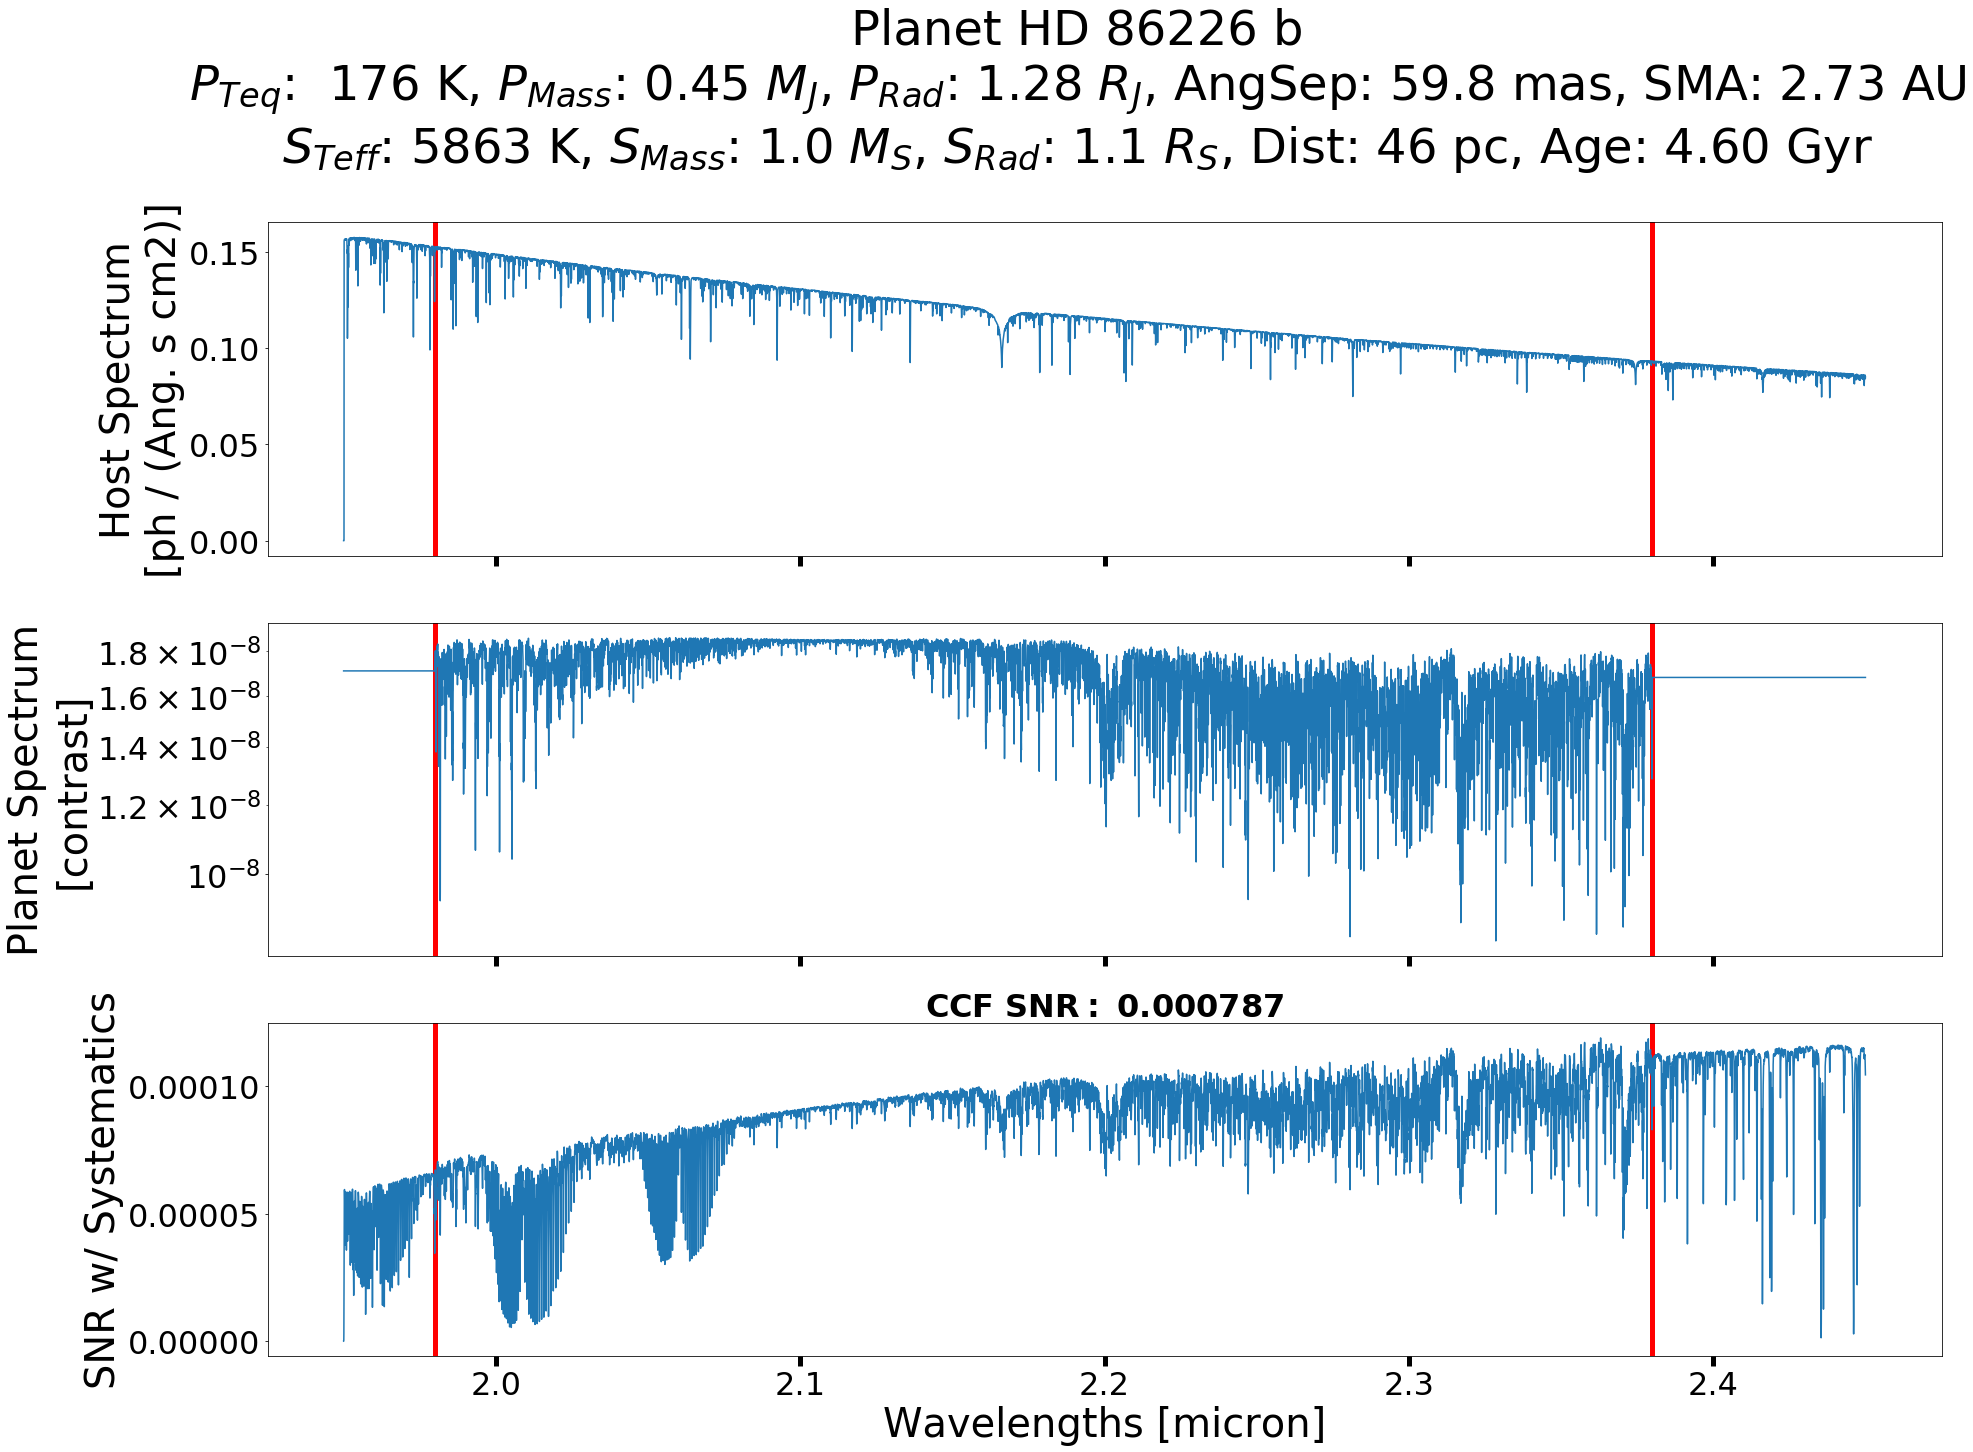

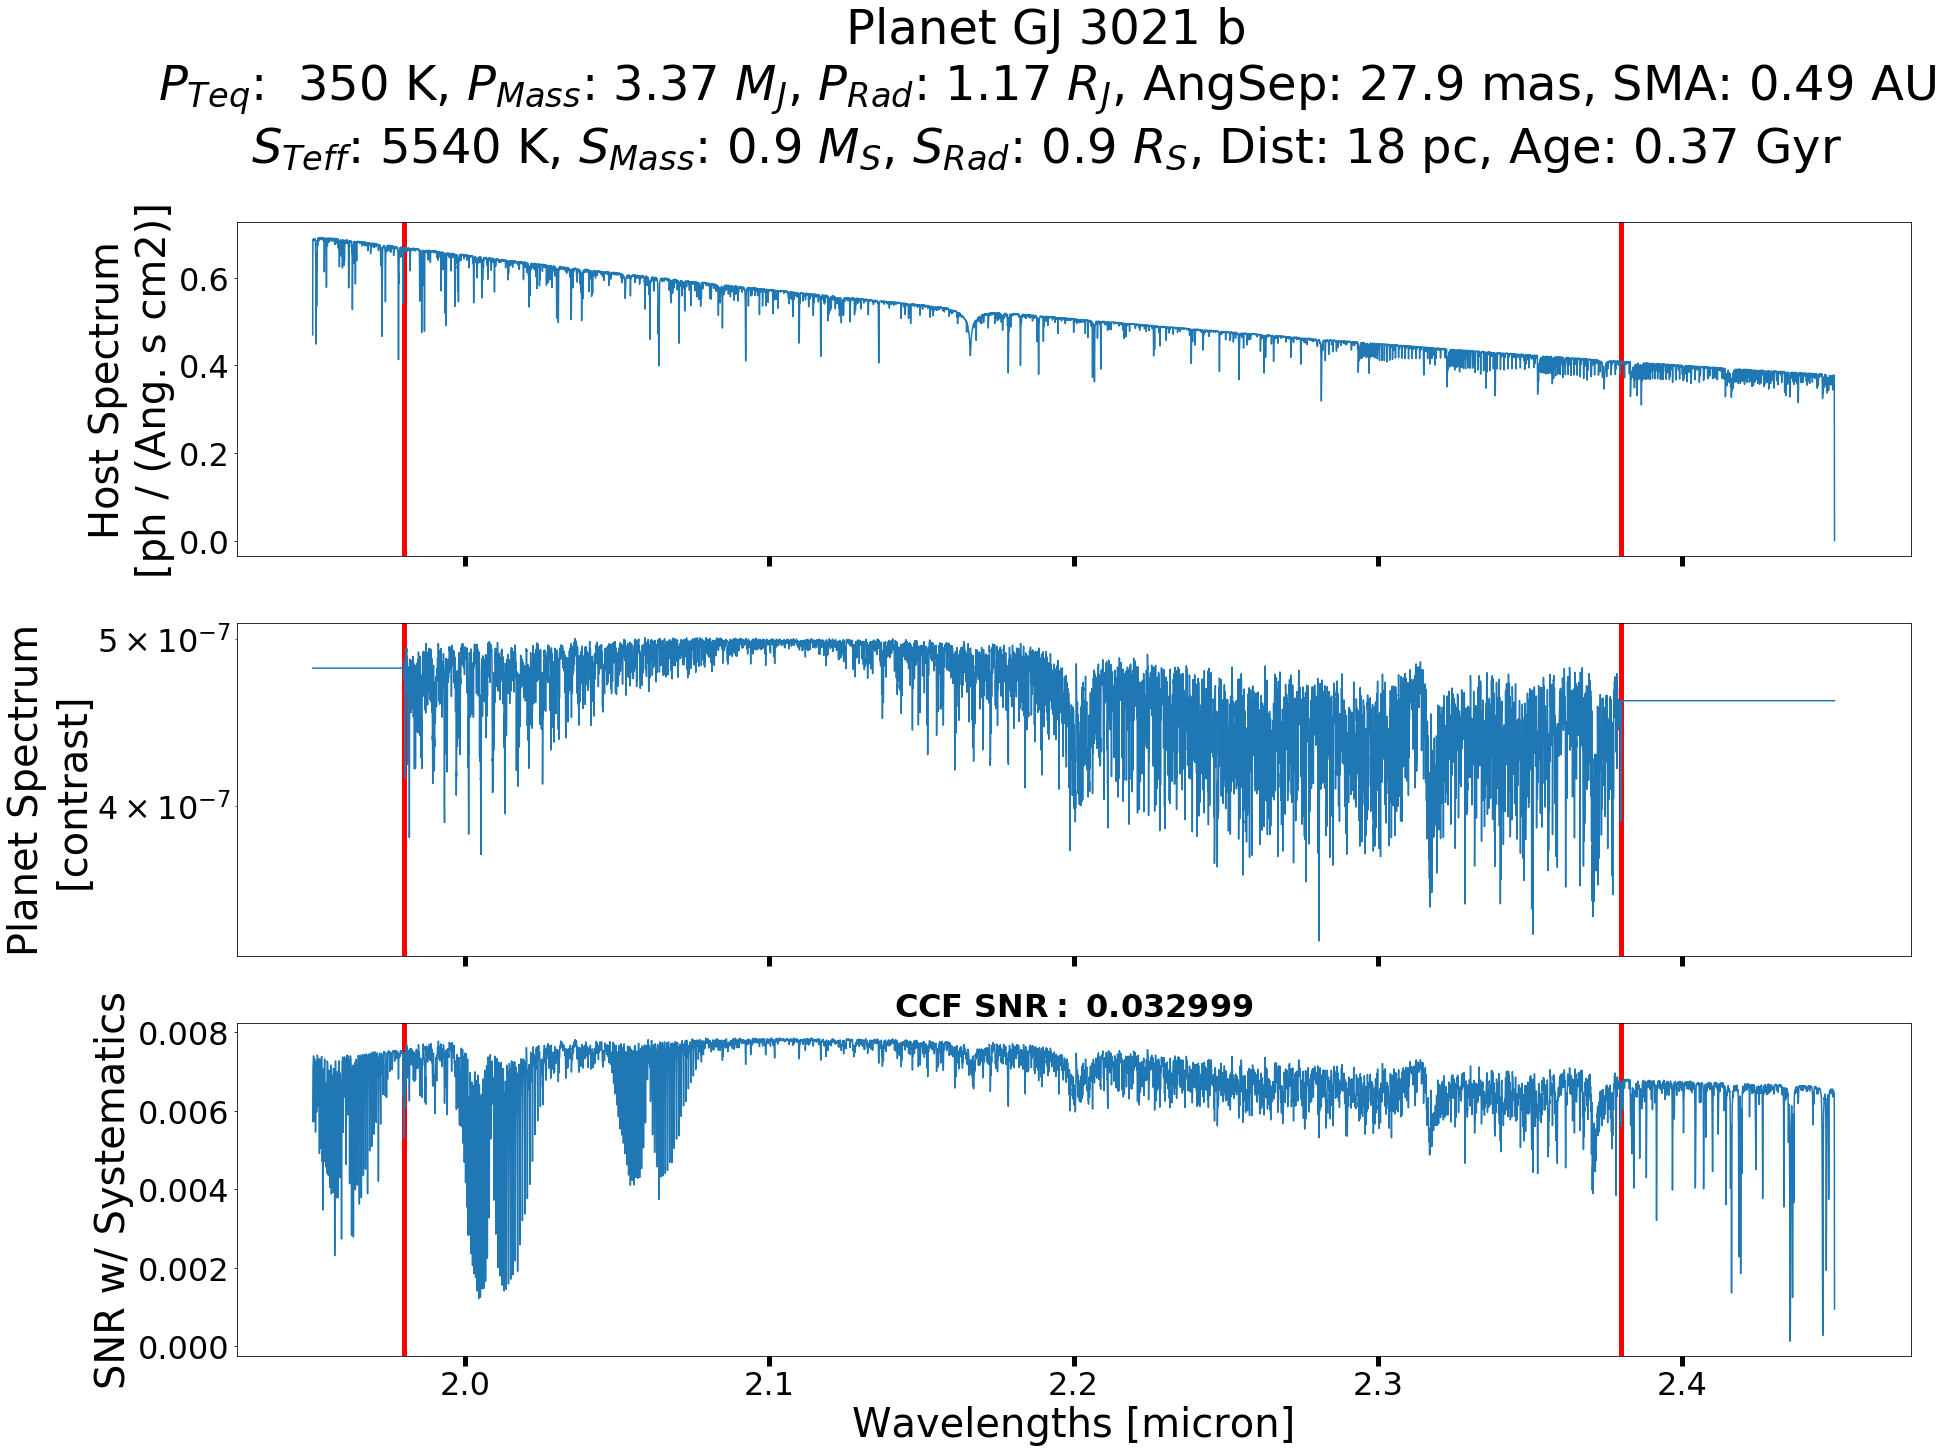

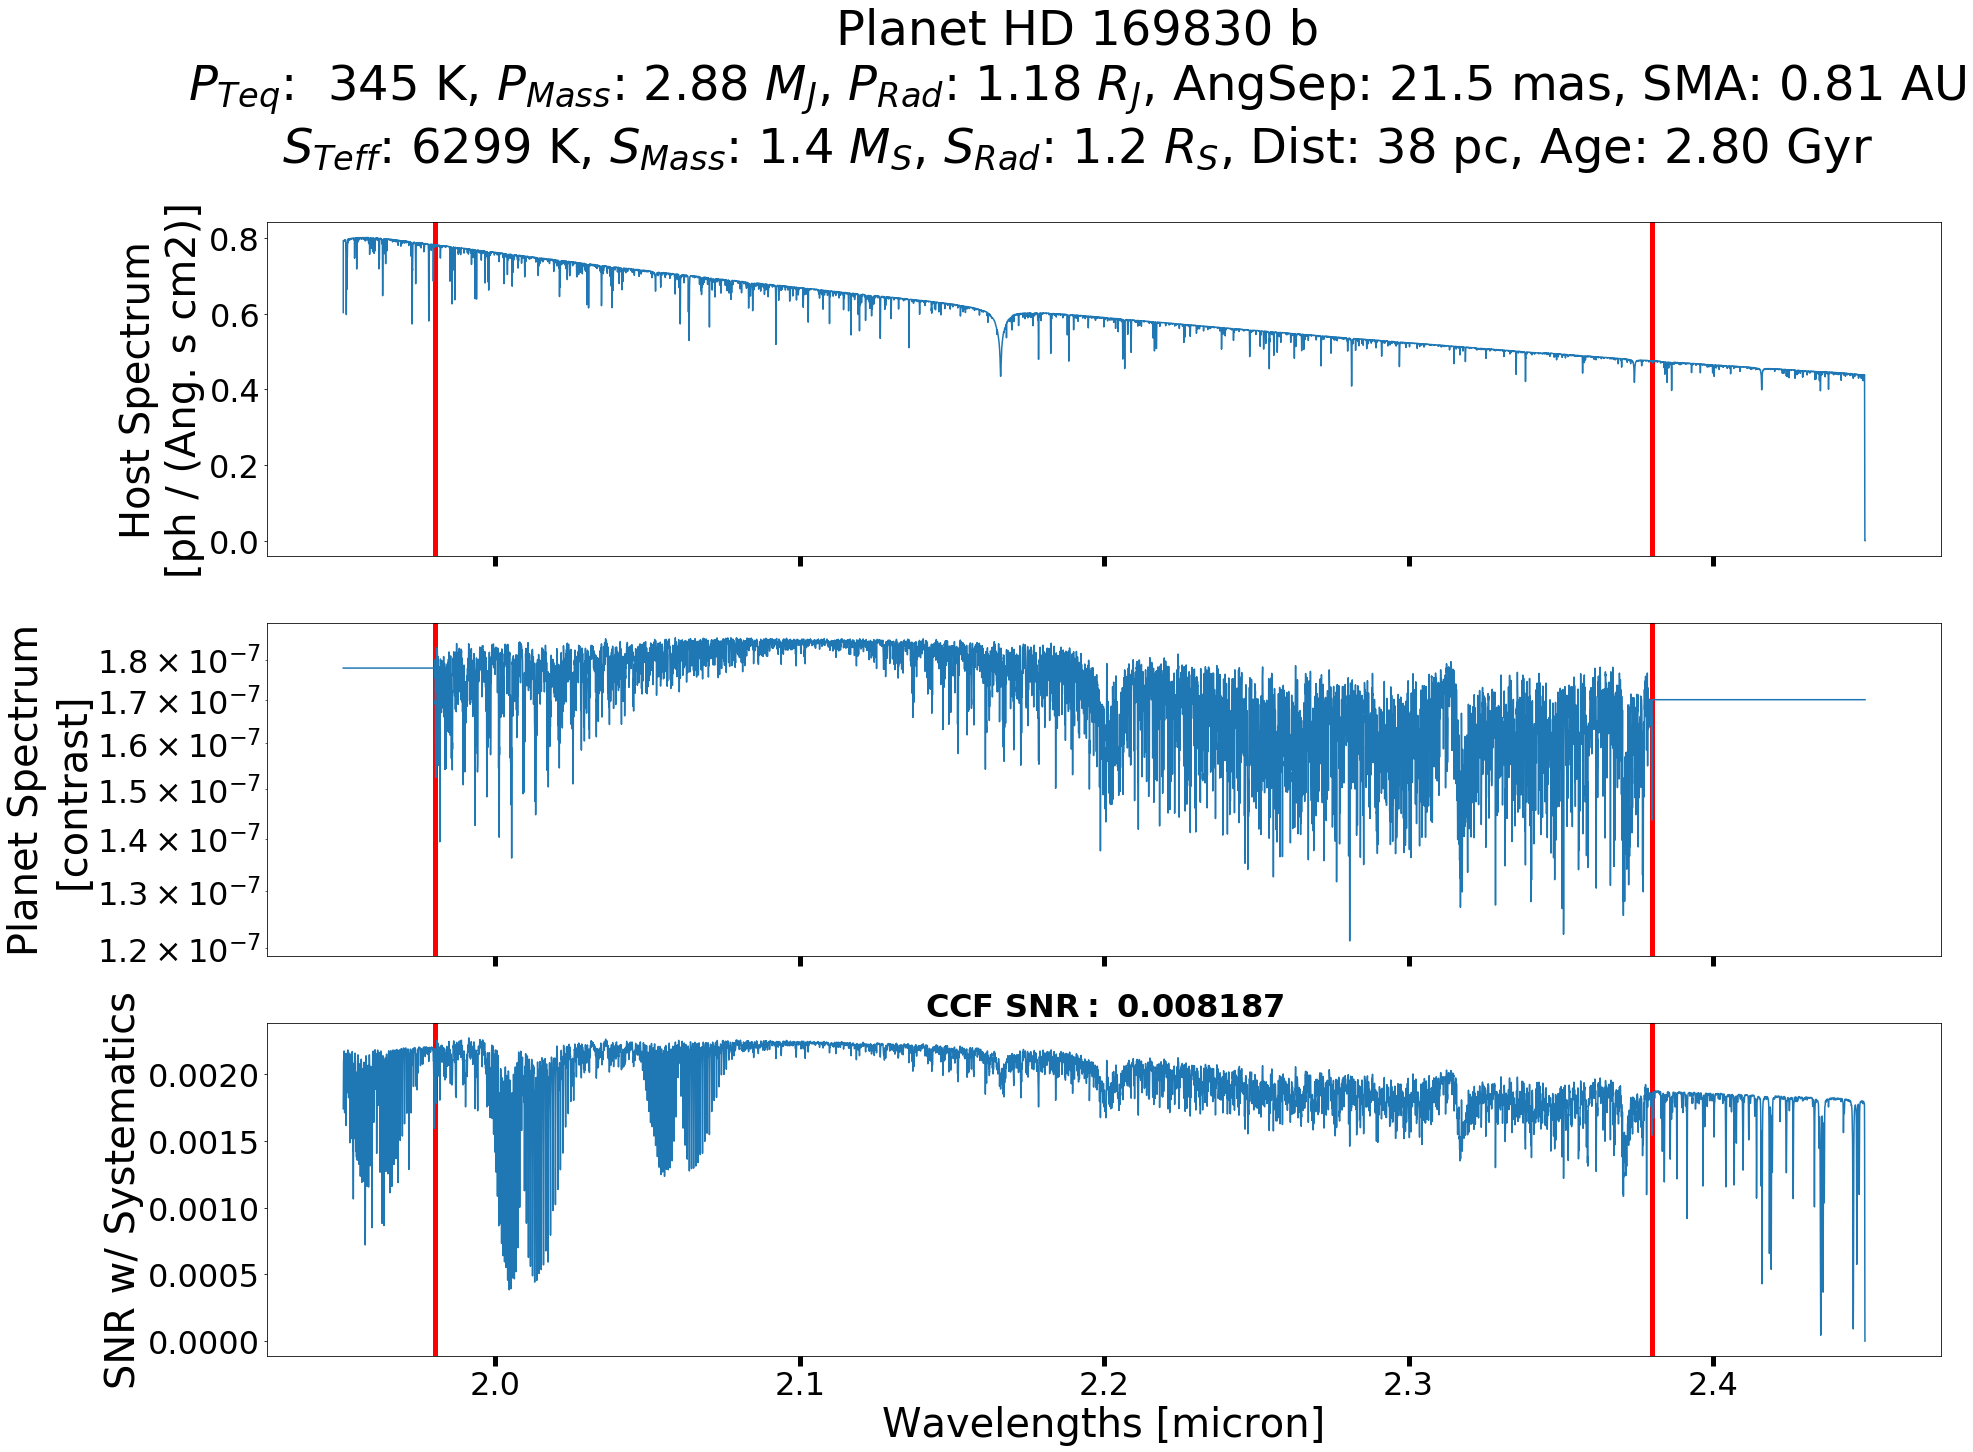

In [25]:
for ind, planet in enumerate(planet_table):
    n_plots = 3
    
    fig, (ax1, ax2, ax3) = plt.subplots(n_plots, sharex=True, figsize=(30,10*n_plots))
    fig.set(facecolor='white')
    tit =  "Planet %s\n"%planet['PlanetName']
    tit += "$P_{Teq}$:  %0.f K, $P_{Mass}$: %.2f $M_{J}$, $P_{Rad}$: %.2f $R{_J}$, AngSep: %.1f mas, SMA: %0.2f AU\n"%(\
            planet['PlanetTeq'].value, planet['PlanetMass'].to(u.jupiterMass).value,
            planet['PlanetRadius'].to(u.jupiterRad).value, planet['AngSep'].value,planet['SMA'].value)
    tit += "$S_{Teff}$: %d K, $S_{Mass}$: %.1f $M_{S}$, $S_{Rad}$: %.1f $R_{S}$, Dist: %.0f pc, Age: %.2f Gyr"%(\
            planet['StarTeff'].value, planet['StarMass'].value, 
            planet['StarRad'].value, planet['Distance'].value, planet['StarAge'].value)
    fig.suptitle(tit, y=0.75)    
    fig.subplots_adjust(top=0.65)
    
    ax1.plot(wavelengths,host_spec_list[ind])
    ax1.axvline(x=wavelengths[wv_min_ind].value,c="r",linewidth=5,zorder=0)
    ax1.axvline(x=wavelengths[wv_max_ind].value,c="r",linewidth=5,zorder=0)
    #ax1.set_title("Host Spectrum")
    ax1.set(ylabel='Host Spectrum\n[ph / (Ang. s cm2)]')
    
    ax2.semilogy(wavelengths,fpfs_ref_list[ind])
    ax2.axvline(x=wavelengths[wv_min_ind].value,c="r",linewidth=5,zorder=0)
    ax2.axvline(x=wavelengths[wv_max_ind].value,c="r",linewidth=5,zorder=0)
    #ax2.set_title('Planet Spectrum')
    ax2.set(ylabel='Planet Spectrum\n[contrast]')
    
    ax3.plot(wavelengths,obj_spec_list[ind]/noise_plus_syst_list[ind])
    ax3.axvline(x=wavelengths[wv_min_ind].value,c="r",linewidth=5,zorder=0)
    ax3.axvline(x=wavelengths[wv_max_ind].value,c="r",linewidth=5,zorder=0)
    ax3.set_title(r'$\bf{CCF\ SNR:\ %f}$'%ccf_list[ind])
    ax3.set(ylabel='SNR w/ Systematics')
    
    
    plt.xlabel('Wavelengths [{}]'.format(wavelengths.unit))
    